In [38]:
# Setup: imports and paths
import os
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
# Resolve raw and clean paths robustly relative to working directory
RAW_CANDIDATES = [
    os.path.join('data', 'koi.csv'),
    os.path.join('..', 'data', 'koi.csv'),
]
RAW_PATH = next((p for p in RAW_CANDIDATES if os.path.isfile(p)), RAW_CANDIDATES[0])
DATA_DIR = os.path.dirname(RAW_PATH) if os.path.basename(RAW_PATH) else os.path.join('data')
CLEAN_PATH = os.path.join(DATA_DIR, 'koi_clean.csv')

In [39]:
# Column groups (kept consistent with the framework)
IDENTIFIER_COLS = [
    'kepid',            # Kepler Catalog ID
    'kepoi_name',       # KOI Name
    'kepler_name',      # Official Kepler Planet Name (if any)
]

TARGET_COL = 'koi_score'

LABEL_COLS = [
    'koi_disposition',     # Exoplanet Archive Disposition
    'koi_pdisposition',    # Disposition Using Kepler Data
    'koi_fpflag_nt',       # Not Transit-Like FP flag
    'koi_fpflag_ss',       # Stellar Eclipse FP flag
    'koi_fpflag_co',       # Centroid Offset FP flag
    'koi_fpflag_ec',       # Ephemeris Match FP flag
]

FEATURE_COLS = [
    # 1) Transit geometry & signal quality
    'koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_model_snr',
    # 2) Planet properties & irradiation
    'koi_prad', 'koi_teq', 'koi_insol',
    # 3) Stellar properties
    'koi_steff', 'koi_slogg', 'koi_srad',
    # 4) Brightness (observation quality)
    'koi_kepmag',
]

# Always drop from feature matrix (metadata), per framework
DROP_ALWAYS = ['koi_tce_plnt_num', 'koi_tce_delivname']

ALL_KEEP_COLS = IDENTIFIER_COLS + [TARGET_COL] + LABEL_COLS + FEATURE_COLS

In [40]:
def clean_koi(raw_path: str, out_path: str) -> pd.DataFrame:
    """
    Load raw KOI CSV, select relevant columns, enforce basic validity of koi_score,
    and save a clean CSV for downstream use.
    """
    # Load raw CSV; ignore NASA header comments starting with '#'
    df = pd.read_csv(raw_path, comment='#', low_memory=False)
    orig_rows = len(df)
    df.columns = df.columns.str.strip()

    # Keep only the specified columns if present
    keep_cols = [c for c in ALL_KEEP_COLS if c in df.columns]
    df = df.loc[:, keep_cols].copy()

    # Drop exact duplicate rows
    before_dupes = len(df)
    df = df.drop_duplicates()
    dropped_dupes = before_dupes - len(df)

    # Coerce numeric columns
    numeric_cols = set(FEATURE_COLS + [TARGET_COL, 'kepid'])
    numeric_cols.update([c for c in LABEL_COLS if c.startswith('koi_fpflag_')])
    numeric_cols = [c for c in numeric_cols if c in df.columns]
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Remove rows with missing target
    before_drop_y_na = len(df)
    df = df.dropna(subset=[TARGET_COL])
    dropped_y_na = before_drop_y_na - len(df)

    # Enforce koi_score within [0, 1]
    before_range = len(df)
    mask_valid = (df[TARGET_COL] >= 0.0) & (df[TARGET_COL] <= 1.0)
    df = df.loc[mask_valid].copy()
    dropped_out_of_range = before_range - len(df)

    # Normalize string columns
    for c in ['kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition']:
        if c in df.columns:
            df[c] = df[c].astype('string').str.strip()

    # Save clean CSV
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df.to_csv(out_path, index=False)

    print(f'Loaded rows: {orig_rows}')
    print(f'Dropped exact duplicates: {dropped_dupes}')
    print(f'Dropped missing koi_score: {dropped_y_na}')
    print(f'Dropped out-of-range koi_score: {dropped_out_of_range}')
    print(f'Kept columns ({len(keep_cols)}): {keep_cols}')
    print(f'Final shape: {df.shape}')
    print(f'Saved to: {out_path}')
    return df

# Run cleaning once to produce data/koi_clean.csv
FORCE_REBUILD = False  # set True to overwrite existing clean file if needed
if FORCE_REBUILD or (not os.path.exists(CLEAN_PATH)):
    _df_clean = clean_koi(RAW_PATH, CLEAN_PATH)
else:
    print(f'Clean file already exists at {CLEAN_PATH}. Set FORCE_REBUILD=True and re-run this cell to rebuild.')

Clean file already exists at ..\data\koi_clean.csv. Set FORCE_REBUILD=True and re-run this cell to rebuild.


In [41]:
# Load the cleaned dataset
import os
import pandas as pd

CLEAN_CANDIDATES = [
    os.path.join('data', 'koi_clean.csv'),
    os.path.join('..', 'data', 'koi_clean.csv'),
]
CLEAN_PATH = next((p for p in CLEAN_CANDIDATES if os.path.isfile(p)), CLEAN_CANDIDATES[0])
df = pd.read_csv(CLEAN_PATH, low_memory=False)

# Re-declare column groups for standalone use of this cell onward
IDENTIFIER_COLS = ['kepid', 'kepoi_name', 'kepler_name']
TARGET_COL = 'koi_score'
LABEL_COLS = ['koi_disposition','koi_pdisposition','koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec']
FEATURE_COLS = [
    'koi_period','koi_impact','koi_duration','koi_depth','koi_model_snr',
    'koi_prad','koi_teq','koi_insol','koi_steff','koi_slogg','koi_srad','koi_kepmag'
]

print(f'Loaded clean dataset: {df.shape[0]} rows x {df.shape[1]} columns')

# Pre-PCA transform specification (fixed per FRAMEWORK)
LOG10_COLS = ['koi_period','koi_duration','koi_prad','koi_teq','koi_insol','koi_srad']
LOG1P_COLS = ['koi_depth','koi_model_snr']
LINEAR_COLS = ['koi_impact','koi_steff','koi_slogg','koi_kepmag']

# Build 12-feature matrix and apply transforms
feat_cols = LOG10_COLS + LOG1P_COLS + LINEAR_COLS
X_pre_pca = df.loc[:, [c for c in feat_cols if c in df.columns]].copy()

# Sanity checks
missing = [c for c in feat_cols if c not in X_pre_pca.columns]
if missing:
    print(f'WARNING: missing expected columns: {missing}')

for c in LOG10_COLS:
    X_pre_pca[c] = np.log10(X_pre_pca[c])
for c in LOG1P_COLS:
    X_pre_pca[c] = np.log10(X_pre_pca[c] + 1.0)

print(f'Prepared pre-PCA feature matrix: {X_pre_pca.shape}')
X_pre_pca.head()


Loaded clean dataset: 8054 rows x 25 columns
Prepared pre-PCA feature matrix: (8054, 12)


,koi_period,koi_duration,koi_prad,koi_teq,koi_insol,koi_srad,koi_depth,koi_model_snr,koi_impact,koi_steff,koi_slogg,koi_kepmag
0,0.977176,0.470925,0.354108,2.899273,1.971229,-0.032920,2.790144,1.565848,0.146,5455.0,4.467,15.347
1,1.735746,0.653888,0.451786,2.646404,0.959518,-0.032920,2.942405,1.428135,0.586,5455.0,4.467,15.347
2,1.298834,0.250956,1.164353,2.804821,1.594393,-0.061480,4.034628,1.888179,0.969,5853.0,4.544,15.436
3,0.239788,0.381370,1.524526,3.144574,2.950345,-0.101824,3.907422,2.704665,1.276,5805.0,4.564,15.597
4,0.402363,0.218667,0.439333,3.147985,2.966686,0.019532,2.781253,1.622214,0.701,6031.0,4.438,15.509


Skipped discrete/binary columns: []
Log10 columns: ['koi_period', 'koi_duration', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_srad']
Log10(1+x) columns: ['koi_depth', 'koi_model_snr']
Linear columns: ['koi_impact', 'koi_steff', 'koi_slogg', 'koi_kepmag']


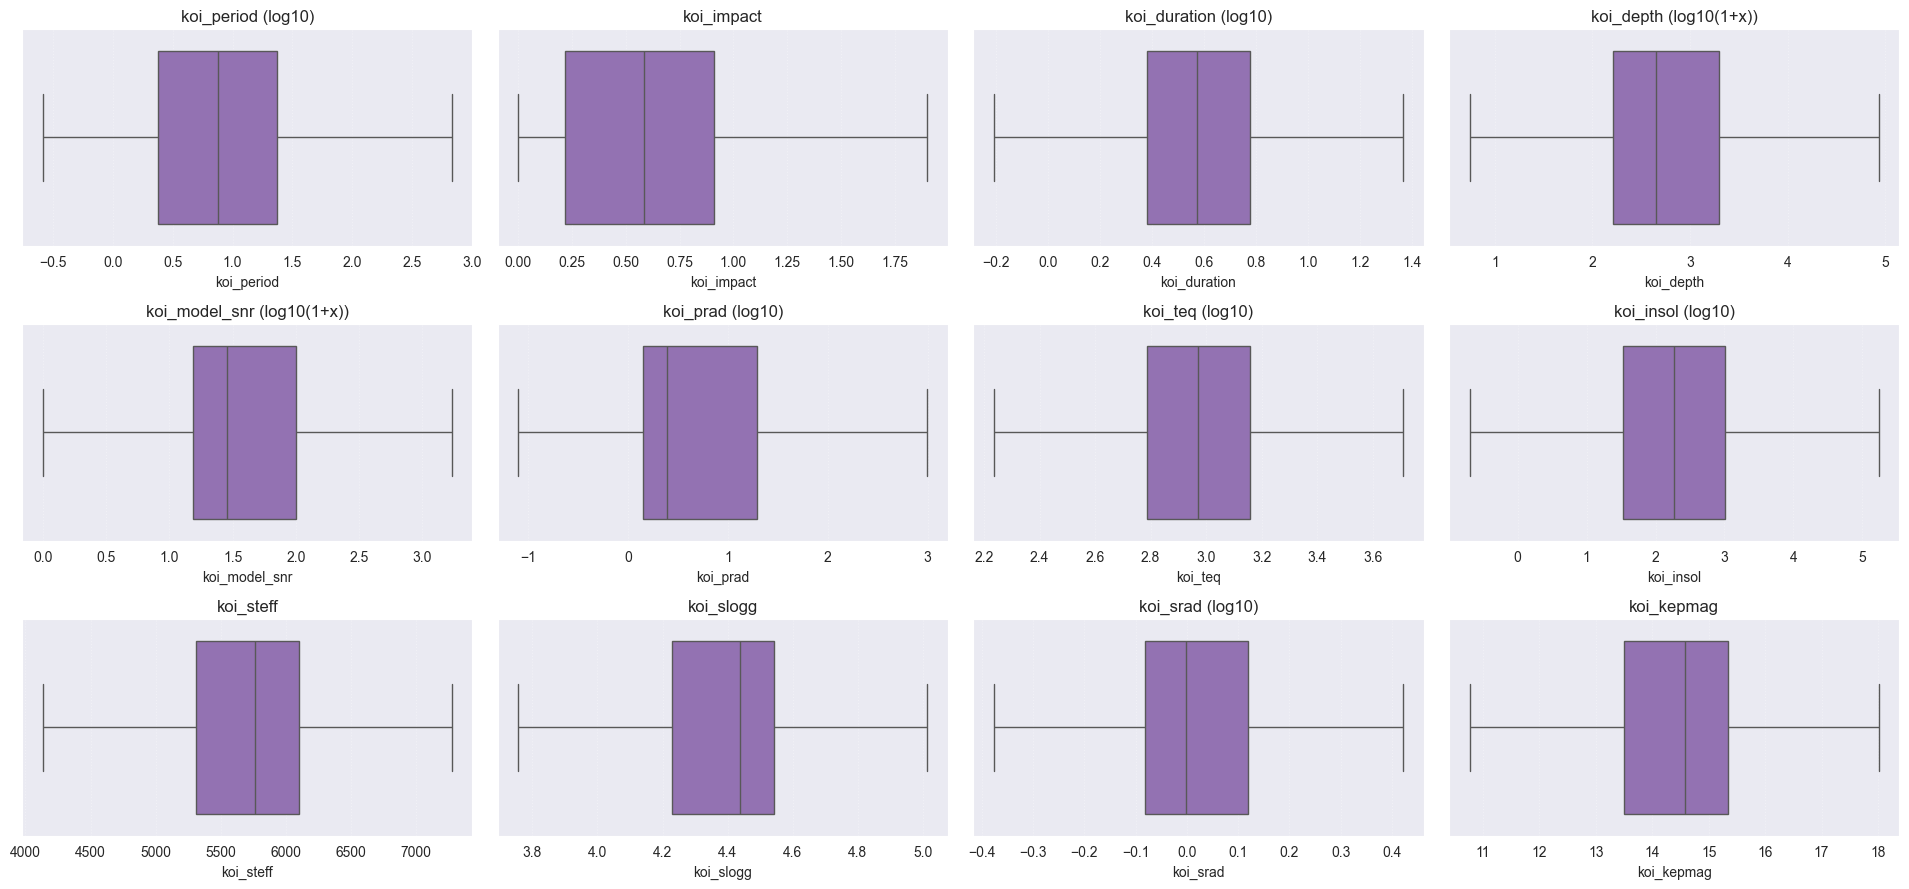

In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use only the 12-feature vector (updated framework)
plot_cols = [c for c in FEATURE_COLS if c in df.columns]
# Identify discrete small-cardinality numeric columns to skip in box plots
discrete_small = [c for c in plot_cols if df[c].nunique(dropna=True) <= 5]
numeric_cols = [c for c in plot_cols if c not in discrete_small]

# Columns we keep linear due to physical meaning (bounded/magnitude)
never_log = {'koi_impact','koi_kepmag'}

log10_cols, log1p_cols, linear_cols = [], [], []
for col in numeric_cols:
    s = pd.to_numeric(df[col], errors='coerce').dropna()
    if col in never_log:
        linear_cols.append(col)
        continue
    if len(s) < 3:
        linear_cols.append(col)
        continue
    skew = float(s.skew())
    q95, q05 = s.quantile(0.95), s.quantile(0.05)
    ratio = (q95 / max(q05, 1e-12)) if q05 > 0 else np.inf
    criterion = (skew > 0.75) or (ratio > 20)
    minv = float(s.min())
    if criterion and minv > 0:
        log10_cols.append(col)
    elif criterion and minv >= 0:
        log1p_cols.append(col)
    else:
        linear_cols.append(col)

# Create transformed copy for plotting
plot_df = df.copy()
for col in log10_cols:
    plot_df[col] = np.log10(plot_df[col])
for col in log1p_cols:
    plot_df[col] = np.log10(plot_df[col] + 1.0)

print('Skipped discrete/binary columns:', discrete_small)
print('Log10 columns:', log10_cols)
print('Log10(1+x) columns:', log1p_cols)
print('Linear columns:', linear_cols)

# Plot box plots using transformed data where applicable
cols_to_plot = numeric_cols
ncols = 4
nrows = math.ceil(len(cols_to_plot) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(4.8 * ncols, 3.0 * nrows), squeeze=False)

for i, col in enumerate(cols_to_plot):
    r, c = divmod(i, ncols)
    ax = axes[r][c]
    sns.boxplot(x=plot_df[col].dropna(), ax=ax, color='#9467bd', orient='h', whis=1.5, showfliers=False)
    tr = ' (log10)' if col in log10_cols else (' (log10(1+x))' if col in log1p_cols else '')
    ax.set_title(col + tr)
    ax.grid(True, axis='x', linestyle=':', alpha=0.35)

# Hide unused axes
total_axes = nrows * ncols
for j in range(len(cols_to_plot), total_axes):
    r, c = divmod(j, ncols)
    axes[r][c].set_visible(False)

plt.tight_layout()
plt.show()


## Pre-PCA 12-feature table
This is the exact 12-D feature matrix X used for PCA and all models.

In [43]:
# Build the 12-feature matrix (order as in FEATURE_COLS) with fixed pre-PCA transforms
X_cols = [c for c in FEATURE_COLS if c in df.columns]
X_12 = df.loc[:, X_cols].copy()

# Ensure transform lists exist (defined earlier)
LOG10_COLS = ['koi_period','koi_duration','koi_prad','koi_teq','koi_insol','koi_srad']
LOG1P_COLS = ['koi_depth','koi_model_snr']
LINEAR_COLS = ['koi_impact','koi_steff','koi_slogg','koi_kepmag']
# Apply transforms in-place, keeping original column order
for c in LOG10_COLS:
    if c in X_12.columns:
        X_12[c] = np.log10(X_12[c])
for c in LOG1P_COLS:
    if c in X_12.columns:
        X_12[c] = np.log10(X_12[c] + 1.0)

print(f'X_12 shape: {X_12.shape}')
X_12.head()


X_12 shape: (8054, 12)


,koi_period,koi_impact,koi_duration,koi_depth,koi_model_snr,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,0.977176,0.146,0.470925,2.790144,1.565848,0.354108,2.899273,1.971229,5455.0,4.467,-0.032920,15.347
1,1.735746,0.586,0.653888,2.942405,1.428135,0.451786,2.646404,0.959518,5455.0,4.467,-0.032920,15.347
2,1.298834,0.969,0.250956,4.034628,1.888179,1.164353,2.804821,1.594393,5853.0,4.544,-0.061480,15.436
3,0.239788,1.276,0.381370,3.907422,2.704665,1.524526,3.144574,2.950345,5805.0,4.564,-0.101824,15.597
4,0.402363,0.701,0.218667,2.781253,1.622214,0.439333,3.147985,2.966686,6031.0,4.438,0.019532,15.509


## Correlation matrix (Pre-PCA X_12)
Pearson correlation of the transformed 12 features.

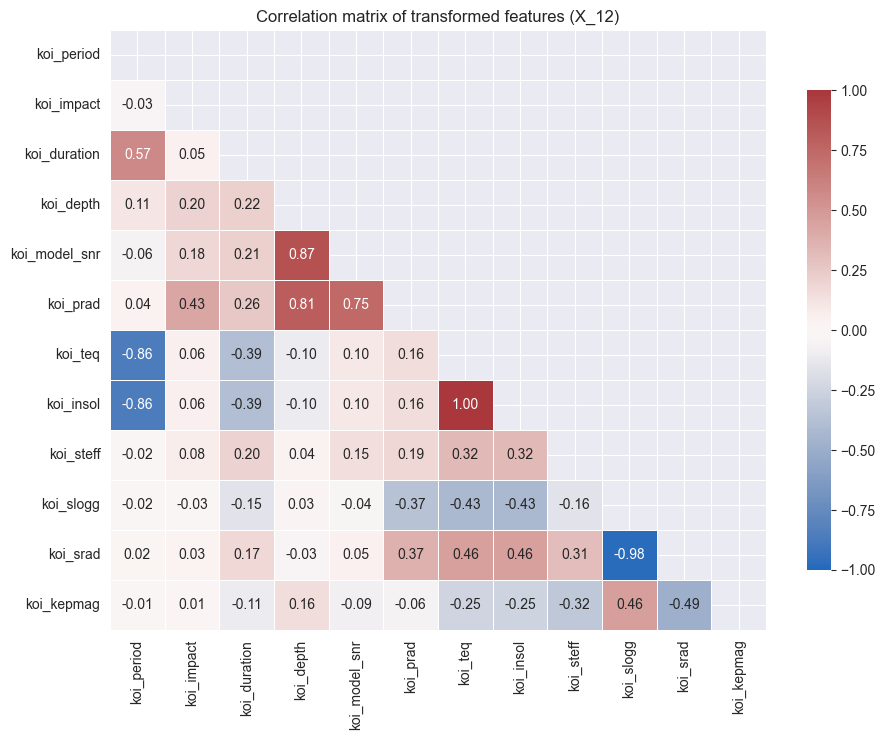

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Guard: require X_12 exists
if 'X_12' not in globals():
    raise RuntimeError('X_12 not found. Run the Pre-PCA 12-feature table cell first.')

corr = X_12.corr(numeric_only=True)

# Mask upper triangle for cleanliness
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(9.5, 7.5))
sns.heatmap(corr, mask=mask, cmap='vlag', vmin=-1, vmax=1, center=0,
            annot=True, fmt='.2f', linewidths=0.5, cbar_kws=dict(shrink=0.8))
plt.title('Correlation matrix of transformed features (X_12)')
plt.tight_layout()
plt.show()


## PCA: eigen decomposition (manual)
Standardize X_12, compute covariance, eigendecomposition, and print eigenvalues and eigenvector matrix A.

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

if 'X_12' not in globals():
    raise RuntimeError('X_12 not found. Run the Pre-PCA 12-feature table cell first.')

scaler = StandardScaler()
X_std = scaler.fit_transform(X_12.astype(float))

# Covariance matrix (features as columns)
cov = np.cov(X_std, rowvar=False)

# Eigendecomposition of symmetric covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov)
# Sort by descending eigenvalue
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# Eigenvector matrix A: columns are principal axes (PC1..PCm)
A = pd.DataFrame(eigvecs, index=X_12.columns, columns=[f'PC{i+1}' for i in range(eigvecs.shape[1])])

print('Eigenvalues (descending):')
print(pd.Series(eigvals, index=[f'PC{i+1}' for i in range(len(eigvals))]).to_string())
print('\nEigenvector matrix A (loadings):', A)

LinAlgError: Eigenvalues did not converge

## PCA: Scree plot and Pareto plot
Explained variance per component and cumulative variance.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Require eigvals from previous cell
if 'eigvals' not in globals():
    raise RuntimeError('Run the PCA eigen decomposition cell first.')

expl_var = eigvals / eigvals.sum()
cum_var = np.cumsum(expl_var)
pcs = np.arange(1, len(eigvals) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Scree
axes[0].plot(pcs, eigvals, 'o-', color='#1f77b4')
axes[0].set_title('Scree Plot (Eigenvalues)')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Eigenvalue')
axes[0].grid(True, linestyle=':', alpha=0.4)
# Pareto
axes[1].bar(pcs, expl_var * 100, color='#1f77b4', alpha=0.7, label='Individual %')
axes[1].plot(pcs, cum_var * 100, 'o-', color='#d62728', label='Cumulative %')
axes[1].set_title('Pareto Plot (Explained Variance)')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('% Variance Explained')
axes[1].set_ylim(0, 110)
axes[1].legend()
axes[1].grid(True, linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 4))
ax = sns.histplot(df['koi_score'].dropna(), bins=40, kde=True, color='#1f77b4', edgecolor='white')
ax.set_title('Distribution of koi_score')
ax.set_xlabel('koi_score')
ax.set_ylabel('Count')
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

print('koi_score summary:')
print(df['koi_score'].describe().to_string())
